In [1]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("((?:[A-Z-][ ]){9,}[A-Z])\s+" +           # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=(?:[A-Z][ ]){9,}|This book \n)")      # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read()
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&rsquo;', "'")
                                   .replace('&lsquo;', "'")
                                   .replace('&rdquo;', '"')
                                   .replace('&ldquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
#         chap_text = re.sub('\n+', '\n', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
# Word Count
for book in hp:
    print('{:,} words in {}'.format(sum(len(hp[book][chapter][1].split()) for chapter in hp[book]), book))
print()    
print('{:,} total words in collection'.format(sum(len(hp[book][chapter][1].split())
                                                for book in hp
                                                for chapter in hp[book])))

79,210 words in Harry Potter and the Sorcerer's Stone
83,597 words in Harry Potter and the Chamber of Secrets
106,457 words in Harry Potter and the Prisoner of Azkaban
193,171 words in Harry Potter and the Goblet of Fire
258,851 words in Harry Potter and the Order of the Phoenix
169,059 words in Harry Potter and the Half-Blood Prince
193,622 words in Harry Potter and the Deathly Hallows

1,083,967 total words in collection


In [5]:
# Average word length
for book in hp:
    text = ''
    for chapter in hp[book]:
        text = text + hp[book][chapter][1]
    print('{:.2f} Average word length in {}'.format(len(text) / len(text.split()), book))

5.55 Average word length in Harry Potter and the Sorcerer's Stone
5.64 Average word length in Harry Potter and the Chamber of Secrets
5.65 Average word length in Harry Potter and the Prisoner of Azkaban
5.61 Average word length in Harry Potter and the Goblet of Fire
5.64 Average word length in Harry Potter and the Order of the Phoenix
5.67 Average word length in Harry Potter and the Half-Blood Prince
5.66 Average word length in Harry Potter and the Deathly Hallows


In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]
print(data[1])

Nearly ten years had passed since the Dursleys had woken up to find their nephew on the front step, but Privet Drive had hardly changed at all. The sun rose on the same tidy front gardens and lit up the brass number four on the Dursleys' front door; it crept into their living room, which was almost exactly the same as it had been on the night when Mr. Dursley had seen that fateful news report about the owls. Only the photographs on the mantelpiece really showed how much time had passed. Ten years ago, there had been lots of pictures of what looked like a large pink beach ball wearing different-colored bonnets — but Dudley Dursley was no longer a baby, and now the photographs showed a large blond boy riding his first bicycle, on a carousel at the fair, playing a computer game with his father, being hugged and kissed by his mother. The room held no sign at all that another boy lived in the house, too. Yet Harry Potter was still there, asleep at the moment, but not for long. His Aunt Petu

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 'hold', 'with', 'such', 'nonsense', 'mr', 'dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning', 'over', 'garden', 'fences', 'spying', 'on', 'the', 'neighbors', 'the', 'dursleys', 'had', 'small', 'son', 'called', 'dudley', 'and', 'in', 'the

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['mr', 'and', 'mrs_dursley', 'of', 'number_four', 'privet_drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 'hold', 'with', 'such', 'nonsense', 'mr_dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs_dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning', 'over', 'garden', 'fences', 'spying', 'on', 'the', 'neighbors', 'the', 'dursleys', 'had', 'small', 'son', 'called', 'dudley', 'and', 'in', 'their', 'opinion', 

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['mr', 'mrs', 'dursley', 'number', 'four', 'privet_drive', 'proud', 'say', 'perfectly', 'normal', 'thank', 'much', 'last', 'people', 'expect', 'involve', 'anything', 'strange', 'mysterious', 'hold', 'nonsense', 'mr', 'dursley', 'director', 'firm', 'call', 'grunning', 'make', 'drill', 'big', 'beefy', 'man', 'hardly', 'neck', 'although', 'large', 'mustache', 'mrs', 'dursley', 'thin', 'blonde', 'nearly', 'twice', 'usual', 'amount', 'neck', 'come', 'useful', 'spend', 'much', 'time', 'crane', 'garden', 'fence', 'spy', 'neighbor', 'dursley', 'small', 'son', 'call', 'dudley', 'opinion', 'fine', 'boy', 'anywhere', 'dursley', 'everything', 'want', 'also', 'secret', 'great', 'fear', 'somebody', 'would', 'discover', 'think', 'could', 'bear', 'anyone', 'find', 'potter', 'mrs', 'potter', 'mrs', 'dursley', 'sister', 'meet', 'several', 'year', 'fact', 'mrs', 'dursley', 'pretend', 'sister', 'sister', 'good', 'nothing', 'husband', 'undursleyish', 'possible', 'dursley', 'shudder', 'think', 'neighbor', 

In [12]:
print(data_lemmatized[19])

['ron', 'breathe', 'harry', 'creep', 'window', 'pushing', 'could', 'talk', 'bar', 'ron', 'harry', 'mouth', 'fall', 'open', 'full', 'impact', 'see', 'hit', 'ron', 'lean', 'back', 'window', 'old', 'turquoise', 'car', 'park', 'midair', 'grin', 'harry', 'front', 'seat', 'fr', 'george', 'ron', 'eld', 'twin', 'brother', 'right', 'harry', 'ask', 'george', 'go', 'say', 'ron', 'answering', 'letter', 'ask', 'stay', 'twelve', 'time', 'dad', 'come', 'home', 'say', 'get', 'official', 'warning', 'use', 'magic', 'front', 'muggle', 'know', 'work', 'ministry', 'say', 'ron', 'know', 'suppose', 'spell', 'outside', 'school', 'talk', 'say', 'harry', 'star', 'float', 'car', 'oh', 'count', 'say', 'ron', 'borrow', 'dad', 'enchant', 'magic', 'front', 'muggle', 'live', 'tell', 'take', 'long', 'explain', 'look', 'tell', 'hogwart', 'dursley', 'lock', 'let', 'come', 'back', 'obviously', 'magic', 'ministry', 'think', 'second', 'spell', 'do', 'three', 'day', 'stop', 'gibber', 'say', 'ron', 'come', 'take', 'home', '-

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 3), (11, 2), (12, 5), (13, 2), (14, 2), (15, 2), (16, 1), (17, 1), (18, 2), (19, 1), (20, 3), (21, 1), (22, 1), (23, 2), (24, 5), (25, 1), (26, 1), (27, 2), (28, 1), (29, 3), (30, 1), (31, 10), (32, 3), (33, 3), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 4), (40, 2), (41, 15), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 3), (49, 2), (50, 3), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 3), (65, 2), (66, 1), (67, 1), (68, 2), (69, 2), (70, 4), (71, 2), (72, 5), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 3), (82, 1), (83, 1), (84, 1), (85, 1), (86, 9), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 4), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 9), (108, 1), (109, 3), (110, 

In [14]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-PRON-', 2),
  ('able', 2),
  ('across', 2),
  ('act', 2),
  ('admire', 1),
  ('affect', 1),
  ('afternoon', 1),
  ('age', 1),
  ('agree', 1),
  ('air', 3),
  ('albus', 3),
  ('allow', 2),
  ('almost', 5),
  ('also', 2),
  ('although', 2),
  ('always', 2),
  ('amount', 1),
  ('amuse', 1),
  ('angrily', 2),
  ('angry', 1),
  ('another', 3),
  ('answer', 1),
  ('anxious', 1),
  ('anyone', 2),
  ('anything', 5),
  ('anywhere', 1),
  ('apart', 1),
  ('appear', 2),
  ('approve', 1),
  ('arm', 3),
  ('armchair', 1),
  ('around', 10),
  ('arrive', 3),
  ('ask', 3),
  ('astonishing', 1),
  ('astounding', 1),
  ('astride', 1),
  ('aunt', 2),
  ('awake', 1),
  ('away', 4),
  ('baby', 2),
  ('back', 15),
  ('bag', 1),
  ('baker', 1),
  ('bakery', 1),
  ('ball', 1),
  ('bathroom', 1),
  ('beady', 1),
  ('bear', 3),
  ('beard', 2),
  ('bed', 3),
  ('bedroom', 1),
  ('beefy', 1),
  ('behave', 1),
  ('behavior', 1),
  ('behind', 1),
  ('believe', 3),
  ('belt', 1),
  ('bend', 1),
  ('beneath', 1)

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.089*"umbridge" + 0.068*"fudge" + 0.015*"dementor" + 0.014*"centaur" + '
  '0.013*"say" + 0.011*"minister" + 0.011*"marietta" + 0.011*"yes" + '
  '0.010*"firenze" + 0.010*"dumbledore"'),
 (1,
  '0.072*"dudley" + 0.064*"uncle_vernon" + 0.034*"aunt_petunia" + '
  '0.034*"harry" + 0.028*"dursley" + 0.013*"letter" + 0.011*"go" + '
  '0.010*"house" + 0.009*"vernon" + 0.009*"room"'),
 (2,
  '0.031*"dursley" + 0.015*"mr" + 0.014*"professor_mcgonagall" + 0.013*"cat" + '
  '0.013*"mrs" + 0.007*"street" + 0.005*"cloak" + 0.004*"owl" + 0.004*"drill" '
  '+ 0.004*"people"'),
 (3,
  '0.002*"polecat" + 0.001*"roan" + 0.001*"sharpish" + 0.001*"crinkled" + '
  '0.001*"moanin" + 0.001*"belted" + 0.001*"disappearing" + 0.001*"stiflingly" '
  '+ 0.001*"ahippo" + 0.001*"windfall"'),
 (4,
  '0.036*"harry" + 0.032*"dumbledore" + 0.020*"say" + 0.015*"goblin" + '
  '0.013*"griphook" + 0.012*"water" + 0.011*"look" + 0.008*"karkaroff" + '
  '0.008*"goblet" + 0.007*"wand"'),
 (5,
  '0.000*"harry" + 0.00

In [17]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -7.52919885550157
Coherence Score:  0.388747091043522


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [19]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('harry', 0.0639386189258312),
   ('dobby', 0.02961367613406919),
   ('sir', 0.026921523758244716),
   ('dumbledore', 0.013326154260331135),
   ('elf', 0.012585812356979404),
   ('potter', 0.011912774263023286),
   ('room', 0.011778166644232063),
   ('find', 0.011307039978462781),
   ('back', 0.011239736169067168),
   ('hear', 0.008884102840220757)]),
 (1,
  [('harry', 0.04756583083048124),
   ('gryffindor', 0.022141510092896558),
   ('wood', 0.018230076133268144),
   ('malfoy', 0.017042676538380947),
   ('team', 0.01648390025843403),
   ('slytherin', 0.015296500663546833),
   ('broom', 0.014737724383599916),
   ('match', 0.011943842983865334),
   ('play', 0.011594607808898512),
   ('snitch', 0.010826290423971503)]),
 (2,
  [('door', 0.028727092620108963),
   ('wizard', 0.020430906389301635),
   ('riddle', 0.015725606736007924),
   ('open', 0.013620604259534423),
   ('witch', 0.01157751362060426),
   ('stand', 0.011391778107974244),
   ('ministry', 0.010710747894997524),
   ('w

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


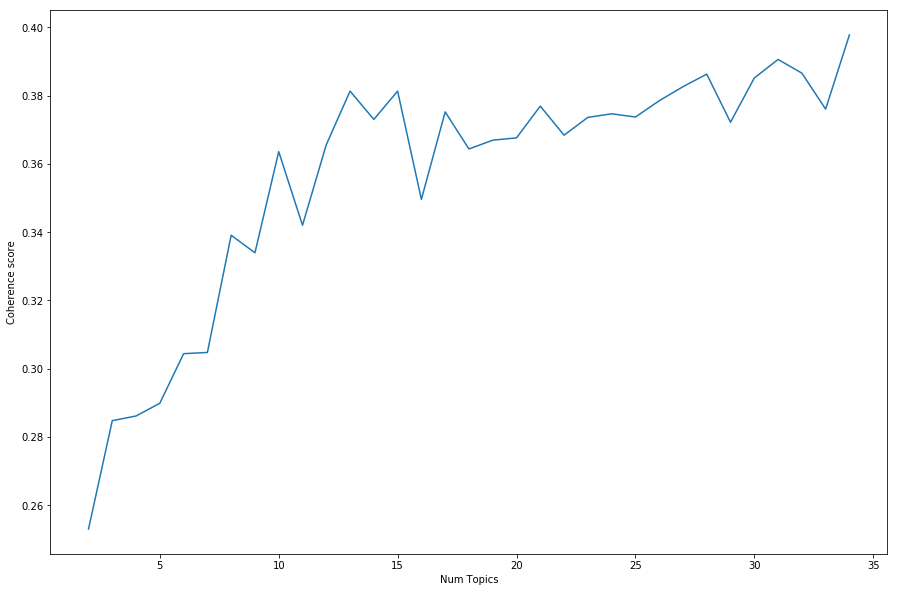

In [23]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.252939
Num Topics = 3  has Coherence Value of 0.284732
Num Topics = 4  has Coherence Value of 0.286091
Num Topics = 5  has Coherence Value of 0.289825
Num Topics = 6  has Coherence Value of 0.304356
Num Topics = 7  has Coherence Value of 0.304711
Num Topics = 8  has Coherence Value of 0.339068
Num Topics = 9  has Coherence Value of 0.333922
Num Topics = 10  has Coherence Value of 0.36357
Num Topics = 11  has Coherence Value of 0.341998
Num Topics = 12  has Coherence Value of 0.365609
Num Topics = 13  has Coherence Value of 0.381315
Num Topics = 14  has Coherence Value of 0.373023
Num Topics = 15  has Coherence Value of 0.381309
Num Topics = 16  has Coherence Value of 0.349585
Num Topics = 17  has Coherence Value of 0.375221
Num Topics = 18  has Coherence Value of 0.364354
Num Topics = 19  has Coherence Value of 0.366933
Num Topics = 20  has Coherence Value of 0.367611
Num Topics = 21  has Coherence Value of 0.376915
Num Topics = 22  has Coherenc

In [25]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 10
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.027*"voldemort" + 0.018*"death_eater" + 0.016*"wand" + 0.008*"eye" + '
  '0.007*"-PRON-" + 0.007*"luna" + 0.007*"goblin" + 0.007*"death" + '
  '0.006*"sword" + 0.006*"long"'),
 (1,
  '0.067*"snape" + 0.032*"harry" + 0.026*"lupin" + 0.021*"black" + '
  '0.021*"sirius" + 0.016*"professor" + 0.015*"potter" + 0.011*"face" + '
  '0.011*"dementor" + 0.011*"professor_mcgonagall"'),
 (2,
  '0.044*"harry" + 0.025*"moody" + 0.023*"dobby" + 0.014*"cedric" + '
  '0.011*"eye" + 0.011*"krum" + 0.009*"potter" + 0.009*"back" + 0.009*"bagman" '
  '+ 0.009*"mr_crouch"'),
 (3,
  '0.039*"harry" + 0.022*"room" + 0.016*"door" + 0.012*"sirius" + '
  '0.011*"voice" + 0.011*"ginny" + 0.011*"feel" + 0.010*"head" + 0.009*"open" '
  '+ 0.009*"inside"'),
 (4,
  '0.109*"ron" + 0.104*"hermione" + 0.099*"harry" + 0.016*"make" + '
  '0.014*"back" + 0.014*"time" + 0.011*"find" + 0.009*"give" + 0.008*"yeah" + '
  '0.007*"thing"'),
 (5,
  '0.099*"hagrid" + 0.023*"harry" + 0.022*"yeh" + 0.018*"ter" + 0.015*"-PRO

In [26]:
optimal_model.show_topic(0,10)

[('voldemort', 0.026583350984960813),
 ('death_eater', 0.017616324225093554),
 ('wand', 0.01634540704652969),
 ('eye', 0.007625503071383181),
 ('-PRON-', 0.007448986796582645),
 ('luna', 0.007095954246981571),
 ('goblin', 0.007025347737061357),
 ('death', 0.0068488314622608204),
 ('sword', 0.006425192402739532),
 ('long', 0.006354585892819318)]

In [27]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['voldemort', 'death_eater', 'wand', 'eye', '-PRON-', 'luna', 'goblin', 'death', 'sword', 'long']
Topic 1: ['snape', 'harry', 'lupin', 'black', 'sirius', 'professor', 'potter', 'face', 'dementor', 'professor_mcgonagall']
Topic 2: ['harry', 'moody', 'dobby', 'cedric', 'eye', 'krum', 'potter', 'back', 'bagman', 'mr_crouch']
Topic 3: ['harry', 'room', 'door', 'sirius', 'voice', 'ginny', 'feel', 'head', 'open', 'inside']
Topic 4: ['ron', 'hermione', 'harry', 'make', 'back', 'time', 'find', 'give', 'yeah', 'thing']
Topic 5: ['hagrid', 'harry', 'yeh', 'ter', '-PRON-', 'back', 'forest', 'fang', 'giant', 'castle']
Topic 6: ['harry', 'wand', 'back', 'head', 'foot', 'hand', 'feel', 'light', 'hear', 'move']
Topic 7: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin', 'professor_mcgonagall', 'filch', 'weasley', 'team', 'wood']
Topic 8: ['dumbledore', 'harry', 'fudge', 'slughorn', 'voldemort', 'time', 'make', 'riddle', 'leave', 'wizard']
Topic 9: ['table', 'good', 'umbridge', 'hand', 'ta

In [28]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.4355,"harry, uncle_vernon, dudley, dursley, back, le...","Mr. and Mrs. Dursley, of number four, Privet D..."
1,1,11.0,0.5723,"harry, uncle_vernon, dudley, dursley, back, le...",Nearly ten years had passed since the Dursleys...
2,2,11.0,0.5779,"harry, uncle_vernon, dudley, dursley, back, le...",The escape of the Brazilian boa constrictor ea...
3,3,11.0,0.3716,"harry, uncle_vernon, dudley, dursley, back, le...",BOOM. They knocked again. Dudley jerked awake....
4,4,5.0,0.2000,"hagrid, harry, yeh, ter, -PRON-, back, forest,...",Harry woke early the next morning. Although he...
5,5,10.0,0.2553,"harry, mrs_weasley, mr_weasley, fr, george, wi...",Harry's last month with the Dursleys wasn't fu...
6,6,7.0,0.3531,"harry, malfoy, ron, gryffindor, slytherin, pro...","The door swung open at once. A tall, black-hai..."
7,7,9.0,0.1604,"table, good, umbridge, hand, talk, neville, ye...","There, look."" ""Where?"" ""Next to the tall kid w..."
8,8,7.0,0.3438,"harry, malfoy, ron, gryffindor, slytherin, pro...",Harry had never believed he would meet a boy h...
9,9,7.0,0.3915,"harry, malfoy, ron, gryffindor, slytherin, pro...",alfoy couldn't believe his eyes when he saw th...


In [29]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
41,41,1.0,0.2050,"snape, harry, lupin, black, sirius, professor,...","In no time at all, Defense Against the Dark Ar..."
43,43,1.0,0.2425,"snape, harry, lupin, black, sirius, professor,...",quo;S MAP Madam Pomfrey insisted on keeping Ha...
45,45,1.0,0.2055,"snape, harry, lupin, black, sirius, professor,...","Harry knew that Hermione had meant well, but t..."
47,47,1.0,0.2257,"snape, harry, lupin, black, sirius, professor,...",quo;S GRUDGE No one in Gryffindor Tower slept ...
51,51,1.0,0.5095,"snape, harry, lupin, black, sirius, professor,...",It took a few seconds for the absurdity of thi...
52,52,1.0,0.4157,"snape, harry, lupin, black, sirius, professor,...",Hermione screamed. Black leapt to his feet. Ha...
55,55,0.0,0.3220,"voldemort, death_eater, wand, eye, -PRON-, lun...",The villagers of Little Hangleton still called...
79,79,1.0,0.2111,"snape, harry, lupin, black, sirius, professor,...",As Harry had no idea how long a bath he would ...
81,81,1.0,0.2170,"snape, harry, lupin, black, sirius, professor,...",One of the best things about the aftermath of ...
87,87,0.0,0.5061,"voldemort, death_eater, wand, eye, -PRON-, lun...",Voldemort looked away from Harry and began exa...


In [30]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'back,',
  'letter,',
  'house,',
  'aunt_petunia,',
  'boy,',
  'make'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'back,',
  'letter,',
  'house,',
  'aunt_petunia,',
  'boy,',
  'make'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'back,',
  'letter,',
  'house,',
  'aunt_petunia,',
  'boy,',
  'make'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'back,',
  'letter,',
  'house,',
  'aunt_petunia,',
  'boy,',
  'make'],
 ['hagrid,',
  'harry,',
  'yeh,',
  'ter,',
  '-PRON-,',
  'back,',
  'forest,',
  'fang,',
  'giant,',
  'castle'],
 ['harry,',
  'mrs_weasley,',
  'mr_weasley,',
  'fr,',
  'george,',
  'wizard,',
  'ministry,',
  'tonk,',
  'ginny,',
  'percy'],
 ['harry,',
  'malfoy,',
  'ron,',
  'gryffindor,',
  'slytherin,',
  'professor_mcgonagall,',
  'filch,',
  'weasley,',
  'team,',
  'wood'],
 ['table,',
  'good,',
  'umbridge,',
  'hand,',
  'talk,',
  'neville,

In [31]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'back']
1. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'back']
2. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'back']
3. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'back']
4. Dominant keywords: ['hagrid', 'harry', 'yeh', 'ter', '-PRON-']
5. Dominant keywords: ['harry', 'mrs_weasley', 'mr_weasley', 'fr', 'george']
6. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
7. Dominant keywords: ['table', 'good', 'umbridge', 'hand', 'talk']
8. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
9. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
10. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
11. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
12. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
13. Dominant keywords:

In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5061,"voldemort, death_eater, wand, eye, -PRON-, lun...",Voldemort looked away from Harry and began exa...
1,1.0,0.5095,"snape, harry, lupin, black, sirius, professor,...",It took a few seconds for the absurdity of thi...
2,2.0,0.3848,"harry, moody, dobby, cedric, eye, krum, potter...","Clutching their purchases, Mr. Weasley in the ..."
3,3.0,0.3399,"harry, room, door, sirius, voice, ginny, feel,...",Mrs. Weasley followed them upstairs looking gr...
4,4.0,0.2658,"ron, hermione, harry, make, back, time, find, ...","quo;S REVENGE Early next morning, before the o..."
5,5.0,0.5242,"hagrid, harry, yeh, ter, -PRON-, back, forest,...",quo;S TALE Harry sprinted up to the boys' dorm...
6,6.0,0.5869,"harry, wand, back, head, foot, hand, feel, lig...",Black shapes were emerging out of thin air all...
7,7.0,0.4649,"harry, malfoy, ron, gryffindor, slytherin, pro...","He — he sent me this,"" Hermione said, holding ..."
8,8.0,0.4920,"dumbledore, harry, fudge, slughorn, voldemort,...",Harry could feel the Felix Felicis wearing off...
9,9.0,0.4088,"table, good, umbridge, hand, talk, neville, ye...",They had expected to have to comb Hermione's D...


In [33]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: voldemort, death_eater, wand, eye, -PRON-, luna, goblin, death, sword, long

Voldemort looked away from Harry and began examining his own body. His hands were like large, pale spiders; his long white fingers caressed his own chest, his arms, his face; the red eyes, whose pupils were slits, like a cat's, gleamed still more brightly through the darkness. He held up his hands and flexed the fingers, his expression rapt and exultant. He took not the slightest notice of Wormtail, who lay twitching and bleeding on the ground, nor of the great snake, which had slithered back into sight and was circling Harry again, hissing. Voldemort slipped one of those unnaturally long-fingered hands into a deep pocket and drew out a wand. He caressed it gently too; and then he raised it, and pointed it at Wormtail, who was lifted off the ground and thrown against the headstone where Harry was tied; he fell to the foot of it and lay there, crumpled up and crying. Voldemort turned hi

In [34]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"voldemort, death_eater, wand, eye, -PRON-, lun...",14,0.0733
1,1.0,"snape, harry, lupin, black, sirius, professor,...",13,0.0681
2,2.0,"harry, moody, dobby, cedric, eye, krum, potter...",11,0.0576
3,3.0,"harry, room, door, sirius, voice, ginny, feel,...",6,0.0314
4,4.0,"ron, hermione, harry, make, back, time, find, ...",10,0.0524
5,5.0,"hagrid, harry, yeh, ter, -PRON-, back, forest,...",10,0.0524
6,6.0,"harry, wand, back, head, foot, hand, feel, lig...",35,0.1832
7,7.0,"harry, malfoy, ron, gryffindor, slytherin, pro...",21,0.1099
8,8.0,"dumbledore, harry, fudge, slughorn, voldemort,...",15,0.0785
9,9.0,"table, good, umbridge, hand, talk, neville, ye...",22,0.1152


In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"voldemort, death_eater, wand, eye, -PRON-, luna, goblin, death, sword, long",14,0.0733
1,1.0,"snape, harry, lupin, black, sirius, professor, potter, face, dementor, professor_mcgonagall",13,0.0681
2,2.0,"harry, moody, dobby, cedric, eye, krum, potter, back, bagman, mr_crouch",11,0.0576
3,3.0,"harry, room, door, sirius, voice, ginny, feel, head, open, inside",6,0.0314
4,4.0,"ron, hermione, harry, make, back, time, find, give, yeah, thing",10,0.0524
5,5.0,"hagrid, harry, yeh, ter, -PRON-, back, forest, fang, giant, castle",10,0.0524
6,6.0,"harry, wand, back, head, foot, hand, feel, light, hear, move",35,0.1832
7,7.0,"harry, malfoy, ron, gryffindor, slytherin, professor_mcgonagall, filch, weasley, team, wood",21,0.1099
8,8.0,"dumbledore, harry, fudge, slughorn, voldemort, time, make, riddle, leave, wizard",15,0.0785
9,9.0,"table, good, umbridge, hand, talk, neville, year, turn, sit, day",22,0.1152


In [36]:
df_dominant_topics.to_csv('df_dominant_topics.csv', index=False)

# LDA using individual sentences as documents

In [37]:
from nltk import tokenize

In [38]:
# Convert to list
data = []
for book in hp:
    for chapter in hp[book]:
        data.extend(tokenize.sent_tokenize(hp[book][chapter][1].replace('\n', '')))

In [39]:
# Convert to list
print('Creating corpus')
data = []
for book in hp:
    for chapter in hp[book]:
        data.extend(tokenize.sent_tokenize(hp[book][chapter][1].replace('\n', '')))

# Tokenize into words
print('Tokenizing')
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
print('Creating bigrams and trigrams')
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
print('Building bigram and trigram models')
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
print('Removing stopwords')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Forming bigrams')
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
print('Lemmatizing')
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
print('Creating dictionary')
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
print('Creating corpus')
texts = data_lemmatized

# Term Document Frequency
print('Creating term frequency list')
corpus = [id2word.doc2bow(text) for text in texts]

Creating corpus
Tokenizing
Creating bigrams and trigrams


/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Building bigram and trigram models
Removing stopwords
Forming bigrams
Lemmatizing
Creating dictionary
Creating corpus
Creating term frequency list


In [40]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [41]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


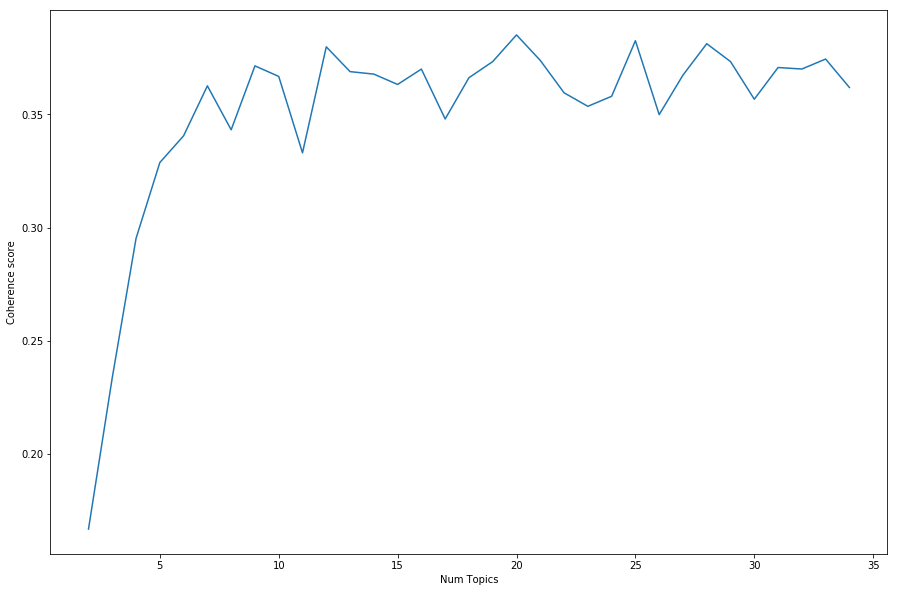

In [42]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.166798
Num Topics = 3  has Coherence Value of 0.2337
Num Topics = 4  has Coherence Value of 0.295204
Num Topics = 5  has Coherence Value of 0.32869
Num Topics = 6  has Coherence Value of 0.340515
Num Topics = 7  has Coherence Value of 0.362566
Num Topics = 8  has Coherence Value of 0.343164
Num Topics = 9  has Coherence Value of 0.371391
Num Topics = 10  has Coherence Value of 0.366742
Num Topics = 11  has Coherence Value of 0.332987
Num Topics = 12  has Coherence Value of 0.379815
Num Topics = 13  has Coherence Value of 0.368854
Num Topics = 14  has Coherence Value of 0.367756
Num Topics = 15  has Coherence Value of 0.363187
Num Topics = 16  has Coherence Value of 0.369973
Num Topics = 17  has Coherence Value of 0.347942
Num Topics = 18  has Coherence Value of 0.366164
Num Topics = 19  has Coherence Value of 0.373297
Num Topics = 20  has Coherence Value of 0.385071
Num Topics = 21  has Coherence Value of 0.373803
Num Topics = 22  has Coherence 

In [44]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 6
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)

In [45]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

Perplexity:  -8.320036847234869
Coherence Score:  0.27952290853882733


/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [46]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['harry', 'voice', 'hear', 'feel', 'head', 'fr', 'george', 'start', 'neville', 'yeah']
Topic 1: ['dumbledore', 'time', '-PRON-', 'potter', 'sirius', 'thing', 'wizard', 'good', 'work', 'magic']
Topic 2: ['harry', 'ron', 'hermione', 'back', 'sit', 'moment', 'put', 'whisper', 'book', 'half']
Topic 3: ['find', 'voldemort', 'leave', 'year', 'hogwart', 'day', 'good', 'boy', 'school', 'happen']
Topic 4: ['door', 'open', 'room', 'foot', 'star', 'move', 'front', 'dark', 'floor', 'fall']
Topic 5: ['turn', 'harry', 'back', 'mr', 'weasley', 'walk', 'end', 'watch', 'table', 'time']
Topic 6: ['hagrid', 'make', 'snape', 'dumbledore', 'harry', 'give', 'malfoy', 'professor', 'lupin', 'stop']
Topic 7: ['eye', 'face', 'hand', 'wand', 'stand', 'long', 'black', 'pull', 'hold', 'large']


In [47]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [48]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [49]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"voldemort, death_eater, wand, eye, -PRON-, luna, goblin, death, sword, long",36173.0,0.3564
1,1.0,"snape, harry, lupin, black, sirius, professor, potter, face, dementor, professor_mcgonagall",12651.0,0.1246
2,2.0,"harry, moody, dobby, cedric, eye, krum, potter, back, bagman, mr_crouch",10374.0,0.1022
3,3.0,"harry, room, door, sirius, voice, ginny, feel, head, open, inside",10188.0,0.1004
4,4.0,"ron, hermione, harry, make, back, time, find, give, yeah, thing",8281.0,0.0816
5,5.0,"hagrid, harry, yeh, ter, -PRON-, back, forest, fang, giant, castle",7974.0,0.0786
6,6.0,"harry, wand, back, head, foot, hand, feel, light, hear, move",8680.0,0.0855
7,7.0,"harry, malfoy, ron, gryffindor, slytherin, professor_mcgonagall, filch, weasley, team, wood",7183.0,0.0708
8,8.0,"dumbledore, harry, fudge, slughorn, voldemort, time, make, riddle, leave, wizard",NaN,NaN
9,9.0,"table, good, umbridge, hand, talk, neville, year, turn, sit, day",NaN,NaN
